# Lab 4: Quantum Error Correction: From Core Concepts to the Road to Fault-Tolerant  Quantum Computing

Welcome to the forth coding challenge of the Qiskit Global Summer School. This lab explores error-correcting codes, beginning with foundational classical error-correcting codes and key concepts. It then transitions to Quantum Error Correction (QEC)—crucial for fault-tolerant quantum computing—covering the stabilizer formalism and key examples. Subsequently, the notebook introduces advanced QEC architectures, including QLDPC, Toric, and Gross codes, with exercises. 

# Table of Contents

- Chapter 1: Classical error-correcting code revisit
  - 1.1 Classical [n, k, d] Codes
  - 1.2 Hamming Distance
  - 1.3 The [3, 1, 3] Repetition Code
    - Practice: Lookup table-based Decoder of [3,1,3] Code
- Chapter 2: Quantum Error Correcting Codes [[n, k, d]]
  - 2.1 Stabilizer Formalism
  - 2.2  3-qubit bit-flip Code Practice
    - Exercise 1: Lookup Table-based Decoder of 3-bit code
  - 2.3 CSS Codes (Calderbank-Shor-Steane)
  - 2.4 [[7,1,3]] Steane Code Practice
    - Exercise 2: Lookup table of [[7,1,3]] Steane Code
    - Exercise 3: Detect Error with a Lookup Table
- Chapter 3: Exploring Advanced Quantum Error Correction Codes & Their Efficiency
  - 3.1 Foundational Concepts and Key QLDPC Architectures for Comparison
  - 3.2 Qubit Layout and Conventions for Exercises
  - 3.3 Toric Code Exercise
      - Exercise 4: Find the parity check matrices of the toric code
  - 3.4 Gross Code Exercise
      - Exercise 5: Find the parity check matrices of the gross code
  - 3.5 Counting the Number of Logical Qubits
      - Exercise 6: Count the number of logicals for the Toric and Gross codes
  - 3.6 Concluding remarks: The power of the connectivity


## Requirements

Before starting this tutorial, please make sure that you have the following installed:

* Qiskit SDK 2.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.40 or later (`pip install qiskit-ibm-runtime`)



In [1]:
#%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

In [2]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.0.2
Grader version: 0.22.6


You should have Qiskit version `>=2.0.0` and Grader `>=0.22.5`. If you see a lower version, you need to reinstall the grader and restart the kernel.

# Imports

In [3]:
# Import common packages first
import numpy as np
from numpy.linalg import matrix_power as m_power

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

# Import utils and cosystems
from lab4_util import hamming_distance, minimum_distance, bring_states, matrixRank
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2  as Sampler

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab4_ex1, 
    grade_lab4_ex2, 
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6
)

# Chapter 1: Classical error-correcting code revisit

## 1.1 Classical [n, k, d] Codes

In coding theory, a classical binary linear block code is often denoted as an $[n, k, d]$ code for messages composed of binary (bit) strings, that is a series of 0s and 1s. These parameters represent:

* **$n$**: The **codeword length**. Each codeword in the code is a binary string of length $n$.
* **$k$**: The **message length**. It represents the number of information bits encoded into a codeword. There are $2^k$ distinct messages and thus $2^k$ unique codewords in the code.
* **$d$**: The **minimum Hamming distance** of the code. This is the smallest Hamming distance between any pair of *distinct* codewords in the code. The minimum distance $d$ determines the code's error detection and correction capabilities.
Only a subset of the $2^n$ possible binary strings represent valid codewords that each carry $k$ bits of information.

## 1.2 Hamming Distance

The **Hamming distance** between two strings (or vectors) of equal length is the number of positions at which the corresponding symbols are different. For binary strings (composed of 0s and 1s), it's simply the count of positions where one string has a '0' and the other has a '1'.

Mathematically, for two binary vectors $x = (x_1, x_2, ..., x_n)$ and $y = (y_1, y_2, ..., y_n)$, the Hamming distance $d_H(x, y)$ is:
$$ d_H(x, y) = \sum_{i=1}^{n} (x_i \oplus y_i) $$
where $\oplus$ denotes the XOR operation (addition modulo 2), this is equivalent to counting the number of '1's in the result of the bitwise XOR operation between $x$ and $y$. This count is also known as the **Hamming weight** of the XOR result.

**Importance**

The Hamming distance is crucial for understanding error correction codes:
1.  **Error Detection**: A code with minimum distance $d$ can detect any error pattern affecting up to $d-1$ bits. If fewer than $d$ bits are flipped during the transmission of a codeword, the resulting string cannot be another valid codeword, so the error is detected.
2.  **Error Correction**: A code with minimum distance $d$ can correct any error pattern affecting up to $t$ bits in a codeword, where $t = \lfloor \frac{d-1}{2} \rfloor$. This is because if at most $t$ errors occur, the received word is still closer (in Hamming distance) to the original codeword than to any other valid codeword.

Here's a Python function to calculate the Hamming distance between two binary strings:


In [4]:
# Example usage:
str1 = "10110"
str2 = "11100"
dist = hamming_distance(str1, str2)
print(f"Hamming distance between '{str1}' and '{str2}' is: {dist}") # Output: 2

vec1 = [1, 0, 0, 1]
vec2 = [0, 0, 1, 1]
dist_vec = hamming_distance(vec1, vec2)
print(f"Hamming distance between {vec1} and {vec2} is: {dist_vec}") # Output: 2

Hamming distance between '10110' and '11100' is: 2
Hamming distance between [1, 0, 0, 1] and [0, 0, 1, 1] is: 2


### Minimum Distance of a Code ($d$)

The minimum Hamming distance $d$ of a code $C$ is the smallest Hamming distance found between any pair of distinct codewords in $C  \subset \{0, 1\}^n$.
$$ d = \min { d_H(c_1, c_2) \mid c_1, c_2 \in C, c_1 \neq c_2 }. $$
For linear codes, where $c_1 \in C$ and $c_2 \in C$ implies $(c_1 +c_2) \in C$, the minimum distance is also equal to the minimum Hamming weight of all non-zero codewords. The Hamming weight of a codeword is its distance from the all-zero codeword.

In [5]:
# --- Example: A Simple [4, 3, 2] Parity Check Code ---
# This code takes 3 message bits (k=3) and adds an even parity bit
# to make the total codeword length n=4.
# Messages: 000, 001, 010, 011, 100, 101, 110, 111
# Codewords (adding even parity bit):
parity_code_4_3 = [
    "0000", # 000 + 0 (even parity)
    "0011", # 001 + 1
    "0101", # 010 + 1
    "0110", # 011 + 0
    "1001", # 100 + 1
    "1010", # 101 + 0
    "1100", # 110 + 0
    "1111"  # 111 + 1
]

# Calculate the minimum distance d
d_parity = minimum_distance(parity_code_4_3)
print(f"Codewords: {parity_code_4_3}")
print(f"Calculated minimum distance d = {d_parity}") # Output: 2

Codewords: ['0000', '0011', '0101', '0110', '1001', '1010', '1100', '1111']
Calculated minimum distance d = 2


So, this is a [4, 3, 2] code.

For our example code parity_code_4_3, we found $d=2$.

- Error Detection: $t_{detect} = d - 1 = 2 - 1 = 1$. This code can detect any single-bit error.
- Error Correction: $t_{correct} = \lfloor \frac{d-1}{2} \rfloor = \lfloor \frac{2-1}{2} \rfloor = \lfloor 0.5 \rfloor = 0$.

In particular, because any single error will result in a string that is not in the codespace, we know an error occured and as such is detected!

However, this code cannot guarantee correction of any errors as the following example of the above codewords shows:
* A bit flip on bit index 0, e.g., 0000 -> 0001 is not a codeword, which can be detected but not corrected as 0001 has the same Hamming distance to 0000, 0011, 0101, and 1001.

Hence, in a [4, 3, 2] code, a single bit-flip error can yield a binary string that is not a codeword but one cannot reliably correct such an error as there is no unique closest codeword for correction, thus it is impossible which of the original codewords was sent.

In general, the reason a code can detect up to $d-1$ errors is that if any such set of bit flips were to occur and corrupt the sent message, then one could identify that the transformed message is no longer a codeword and as such detect that some set of errors occurred.  While correcting such errors is more involved, any error of weight at most $\lfloor \frac{d-1}{2} \rfloor$ can be corrected as one can consider the corrupted codeword and look at all possible codewords within Hamming distance $\lfloor \frac{d-1}{2} \rfloor$ and there will only be one such possibility. Doing this task efficiently, also known as decoding, is in general a non-trivial task that is an active area of research, depending on the code.

To investigate this further, let's recalculate for a different code, e.g., the [3, 1, 3] repetition code $C = { 000, 111 }$.

## 1.3 The [3, 1, 3] Repetition Code

The simplest error-correcting code is the repetition code.
To send a single bit (k=1), we repeat it `n` times. For the `[3,1,3]` code, we repeat the bit 3 times.
-   Message `0` is encoded as `000`.
-   Message `1` is encoded as `111`.

Here, n=3, k=1.
The codewords are {000, 111}.
The Hamming distance between 000 and 111 is 3. So, $d=3$.
This code can detect up to $d-1 = 2$ errors.
It can correct up to $\lfloor((d-1)/2)\rfloor = \lfloor((3-1)/2)\rfloor$ = 1 error.

**Encoding:**
-   If message bit is `m`, codeword `c = mmm`.

**Error & Decoding (Majority Vote):**
Suppose a codeword `c` is transmitted, and `c'` is received.
If at most one bit is flipped, the original message can be recovered by majority voting.
-   Receive `000` -> Decode `0`
-   Receive `001` -> Decode `0` (1 error)
-   Receive `010` -> Decode `0` (1 error)
-   Receive `100` -> Decode `0` (1 error)
-   Receive `111` -> Decode `1`
-   Receive `110` -> Decode `1` (1 error)
-   Receive `101` -> Decode `1` (1 error)
-   Receive `011` -> Decode `1` (1 error)

If two bits are flipped (e.g., `000` -> `011`), majority voting decodes to the wrong message (`1` in this case). The code can detect this as a 2-bit error but cannot correct it.

Let's first check the minimum distance of this code with Error detection capability and error correction capability.

In [6]:
# --- Example: [3, 1, 3] Repetition Code ---
repetition_code_3_1 = ["000", "111"]
d_repetition = minimum_distance(repetition_code_3_1)
print(f"Calculated minimum distance d = {d_repetition}") # Output: 3

# Capabilities for d=3:
t_detect = d_repetition - 1
t_correct = int((d_repetition - 1) / 2) // 1
print(f"Error Detection Capability (t_detect = d-1): {t_detect}") # Output: 2
print(f"Error Correction Capability (t_correct = floor((d-1)/2)): {t_correct}") # Output: 1

Calculated minimum distance d = 3
Error Detection Capability (t_detect = d-1): 2
Error Correction Capability (t_correct = floor((d-1)/2)): 1


### Practice: Lookup table-based Decoder of [3,1,3] Code

Since this code can correct errors, we can now create a lookup table-based decoder in the form of a dictionary to perform error correction. A lookup table-based decoder maps every possible received 3-bit string to the most likely transmitted 1-bit message, which regard to the corrected message. Here we will use a helper function `Hamming_distance` to see how Hamming distance affect on correcting error. First let do a simple test with one single case.

In [7]:
test_str = "010"

print("Hamming distance between 010 and 000 is", hamming_distance(test_str, "000"))
print("Hamming distance between 010 and 111 is", hamming_distance(test_str, "111"))

Hamming distance between 010 and 000 is 1
Hamming distance between 010 and 111 is 2


\"000\" is a logical `0` and \"111\" is a logical `1`, so this `test_str` will be corrected as `0`. Try to complete below dictionary to complete whole lookup table-based decoder of [3,1,3] classical error correcting code by mapping final corrected string per received string.

Before checking the solution table below, it's helpful to understand its columns: 'received text' is the 3-bit string that was observed after potential errors; 'Hamming distance with "000"' and 'Hamming distance with "111"' show how many bits differ from the two valid logical codewords (000 and 111, respectively); and 'Corrected str' is the single bit (0 or 1) that the decoder determines was the original message.

In [8]:
hardcode_decoder_3_1_3 = {
    '000': '0',
    '001': '',
    '010': '',
    '011': '',
    '100': '',
    '101': '',
    '110': '',
    '111': '1'
}

<details>
<summary> Check your decoder with this! </summary>

| received text | Hamming distance with "000" | Hamming distance with "111" | Corrected str |
|---|---|---|---|
|000|0|3|0|
|001|1|2|0|
|010|1|2|0|
|011|2|1|1|
|100|1|2|0|
|101|2|1|1|
|110|2|1|1|
|111|3|0|1|

</details>



# Chapter 2. Quantum Error Correcting Codes [[n, k, d]]

Quantum information is much more fragile than classical information. Qubits are susceptible to various types of errors, not just bit-flips ($X$ errors) but also phase-flips ($Z$ errors) and combinations of both ($Y$ errors). Quantum error correction (QEC) aims to protect quantum states from these errors.

A quantum error correcting code is often denoted by `[[n, k, d]]`, where:

* **`n`**: The number of **data qubits** used to construct the code.
* **`k`**: The number of **logical qubits** encoded by the code. This means the code protects a $2^k$-dimensional logical state space (codespace).
* **`d`**: The **minimum distance** of the code. This is the minimum qubits an operator needs to act on to perform a non-identity operation on a logical qubit. In the case of stabilizer codes that follows, it is the minimum number of qubits a Pauli operator must act on in order to apply a logical Pauli operator. 

<div class="alert alert-block alert-info">

<b>Note on resource overhead:</b>
    
It's important to note that the `n` in the `[[n, k, d]]` notation typically refers to the data qubits involved in the code block. This count usually *omits* any ancilla or syndrome qubits required for tasks like error detection and correction. Therefore, the total resource overhead is not simply `n - k` data qubits, but rather `(n - k)` (the number of redundant data qubits) *plus* the number of ancilla qubits needed for syndrome measurements. In many stabilizer codes, the number of independent stabilizers (and thus often the number of ancilla qubits) is `n - k`, but this can vary, and in some schemes, the ancilla count could be significant, potentially as large as `n`.
</div>

Similar to classical codes, the minimum distance $d$ determines the code's error correction capability. An `[[n, k, d]]` code can detect up to `d-1` errors and can potentially correct up to `floor((d-1)/2)` arbitrary single-qubit errors.

## 2.1 Stabilizer Formalism


The stabilizer formalism is a powerful framework for constructing and understanding many QEC codes.

-   The **Pauli group** $P_n$ on $n$ qubits consists of all $n$-fold tensor products of Pauli matrices $\{I, X, Y, Z\}$, multiplied by overall factors $\{\pm 1, \pm i\}$.
-   A **stabilizer code** is defined by its **stabilizer group S**, which is an abelian subgroup of $P_n$ such that $-I \notin S$.
-   The **codespace C(S)** is the subspace of $(\mathbb{C}^2)^{\otimes n}$ simultaneously stabilized by all elements of $S$. That is, for any state $|\psi\rangle \in C(S)$ and any $g \in S$, $g|\psi\rangle = |\psi\rangle$. So, states in the codespace are +1 eigenstates of all stabilizer operators.
-   Typically, $S$ is specified by a set of $m = n-k$ independent and commuting generators $S = \langle g_1, g_2, ..., g_m \rangle$.

A comprehensive resource is the IBM Quantum Learning course by John Watrous: [Foundations of Quantum Error Correction](https://learning.quantum.ibm.com/course/foundations-of-quantum-error-correction). If you wish to delve deeper into the mathematical details and further examples, exploring such resources is highly recommended. Click `Stabilizer Formalism Summary` to see the summary, or you can skip this.


<details>
  <summary><b>Stabilizer Formalism Summary</b></h3></summary>

  Many powerful Quantum Error Correcting Codes (QECCs), including the 3-qubit repetition code discussed below and the famous Steane (`[[7, 1, 3]]`) and Shor (`[[9, 1, 3]]`) codes, belong to the family of **stabilizer codes**. The stabilizer formalism provides a powerful framework for defining quantum codes and designing error detection/correction procedures.

**1. Stabilizing States and Subspaces:**

* An operator $S$ is said to **stabilize** a quantum state $|\psi\rangle$ if $|\psi\rangle$ is an eigenstate of $S$ with eigenvalue +1. That is, $S|\psi\rangle = |\psi\rangle$.
* An operator $S$ stabilizes a subspace (the **codespace**, denoted $\mathcal{C}$) if it stabilizes *every* state $|\psi\rangle$ within that subspace: $S|\psi\rangle = |\psi\rangle$ for all $|\psi\rangle \in \mathcal{C}$.

**2. The Stabilizer Group ($\mathcal{S}$):**

* For a given stabilizer code, the set of all operators that stabilize the codespace $\mathcal{C}$ forms a mathematical group called the **stabilizer group**, denoted $\mathcal{S}$.
* **Key Properties:**
    * All operators $S_i, S_j$ in the group $\mathcal{S}$ must **commute** with each other: $S_i S_j = S_j S_i$.
    * Stabilizer operators are typically constructed from tensor products of **Pauli operators** ($I, X, Y, Z$) acting on $n$ qubits. For example, $X \otimes Z \otimes I \otimes X$ could be a stabilizer element for $n=4$.
    * The identity operator $I^{\otimes n}$ is always an element of $\mathcal{S}$. By convention, $-I^{\otimes n}$ is usually excluded.

**3. Generators ($\{g_i\}$):**

* Instead of listing all elements of the potentially large group $\mathcal{S}$, we define it using a smaller set of **generators**, $g_1, g_2, ..., g_{n-k}$.
* Any element $S \in \mathcal{S}$ can be created by taking products of these generators (e.g., $g_1 g_3$, $g_2 g_5 g_1$, etc.).
* **Key Properties of Generators:**
    * They must **commute** with each other: $[g_i, g_j] = 0$ for all $i, j$.
    * They must be **independent**: no generator can be formed by multiplying the others in the set.
    * There are $n-k$ independent generators for an `[[n, k, d]]` code.

**4. Defining the Codespace ($\mathcal{C}$):**

* The codespace $\mathcal{C}$ of a stabilizer code is the **simultaneous +1 eigenspace** of all its generators (and thus all elements in $\mathcal{S}$).
* If a state $|\psi\rangle$ is in the codespace, it must satisfy $g_i |\psi\rangle = |\psi\rangle$ for all generators $i=1, ..., n-k$.
* Starting with the full $2^n$-dimensional Hilbert space of $n$ physical qubits, each independent generator effectively halves the dimension of the subspace it stabilizes. Therefore, $n-k$ independent generators define a $2^{n-(n-k)} = 2^k$-dimensional codespace, which is exactly the space needed to encode $k$ logical qubits.

**5. Error Detection using Stabilizers:**

* The primary function of stabilizers in QEC is **error detection**. This works by measuring the eigenvalues of the stabilizer generators.
* **No Error:** If the system is in a valid codespace state $|\psi\rangle \in \mathcal{C}$ and no error occurs, measuring any generator $g_i$ will yield the outcome +1 with certainty (because $g_i|\psi\rangle=|\psi\rangle$).
* **Error Occurs:** Suppose an error $E$ (a Pauli operator product) occurs, transforming the state to $E|\psi\rangle$. Now, measure a generator $g_i$.
    * If $g_i$ **commutes** with the error $E$ (i.e. $g_i E = E g_i$):
        - $g_i (E |\psi\rangle) = E g_i |\psi\rangle = E |\psi\rangle$. The measurement outcome is still +1. The error $E$ is *not detected* by $g_i$.
    * If $g_i$ **anti-commutes** with the error $E$ (i.e. $g_i E = -E g_i$):
        - $g_i (E |\psi\rangle) = -E g_i |\psi\rangle = -E |\psi\rangle$. The measurement outcome is -1. The error $E$ *is detected* by $g_i$.
* **Error Syndrome:** The set of measurement outcomes (+1 or -1, often mapped to 0 or 1 respectively) for all the generators $\{g_1, ..., g_{n-k}\}$ constitutes the **error syndrome**.
    * A syndrome of all +1s (or all 0s) indicates either no error occurred or an error occurred that commutes with all stabilizers (which might be a logical operator or an undetectable error related to the code's distance $d$).
    * A non-trivial syndrome (containing at least one -1 or 1) indicates that a detectable error has occurred. The specific pattern of the syndrome provides information about the likely error $E$ that occurred, which can then be used for correction.

**Connection to `[[n, k, d]]`:**

* `n` is the number of physical qubits the stabilizers act on.
* `k` is the number of encoded logical qubits, determined by $k = n - (\text{number of independent generators})$.
* `d` is the minimum weight of a Pauli error $E$ that commutes with all stabilizers ($[E, g_i]=0$ for all $i$) but is *not* itself a product of stabilizers (i.e., $E \notin \mathcal{S}$). Such an operator is a **logical operator** (acting non-trivially on the encoded information) or an undetectable error. The distance $d$ quantifies the code's ability to distinguish between the effects of low-weight errors.
</details>



Stabilizer formalism provides the foundation for understanding how codes like the `[[7, 1, 3]]` example (below) are constructed and how they detect errors of any type.

## 2.2 3-qubit bit-flip Code Practice

(Note: Throughout this explanation, we use Qiskit's little-endian convention where the rightmost character in a Pauli string corresponds to qubit 0, e.g., `IZZ` acts as $I_2 \otimes Z_1 \otimes Z_0$.)

This code is the quantum analogue of the classical [3,1,3] repetition code. It can correct a **single bit-flip (X) error** on any of the three physical qubits, however it will not be able to correct for $Z$ phase errors.
-   n=3 physical qubits, k=1 logical qubit. The goal of the code is to preserve the state of the logical qubit despite errors on the physical qubits.
-   Logical states (unnormalized):
    -   $|0_L\rangle \equiv |000\rangle$
    -   $|1_L\rangle \equiv |111\rangle$
    - An arbitrary logical state is $\alpha|0_L\rangle + \beta|1_L\rangle = \alpha|000\rangle + \beta|111\rangle$.

**Stabilizer Generators:**
This code is stabilized by:
-   $S_0 = Z_2 Z_1 I_0$ (or simply $Z_1Z_2$)
-   $S_1 = I_2 Z_1 Z_0$ (or simply $Z_0Z_1$)
These are Z-type stabilizers, which are used to detect X-errors (bit flips).

**Logical Operators:**
-   Logical Z: $\bar{Z} = Z_0$ (or $Z_1$ or $Z_2$, as $Z_0|0_L\rangle = |0_L\rangle, Z_0|1_L\rangle = -|1_L\rangle$). A common choice is $Z_2 Z_1 Z_0$.
-   Logical X: $\bar{X} = X_2 X_1 X_0$. $(\bar{X}|0_L\rangle = |1_L\rangle, \bar{X}|1_L\rangle = |0_L\rangle)$.

**Error Detection (Syndrome Extraction):**
Let $s_0, s_1$ be the eigenvalues (-1 if flipped, +1 if not) for $S_0, S_1$ respectively. The syndrome is $(s_0, s_1)$.
-   No error: $(+1, +1)$
-   $X_0$ error (bit flip on qubit 0): $S_0$ commutes, $S_1$ anticommutes ($Z_0Z_1X_0 = -X_0Z_0Z_1$). Syndrome: $(s_1,s_0) = (-1, +1)$. Correction: Apply $X_0$.
-   $X_1$ error (bit flip on qubit 1): $S_0$ anticommutes, $S_1$ anticommutes. Syndrome: $(-1, -1)$. Correction: Apply $X_1$.
-   $X_2$ error (bit flip on qubit 2): $S_0$ anticommutes, $S_1$ commutes. Syndrome: $(+1, -1)$. Correction: Apply $X_2$.

<div class="alert alert-block alert-info">
    
**Vulnerability to Z-errors**
    
One thing to keep in mind is, this code is primarily designed to protect against bit-flip (X-type) errors. It's crucial to note this code does undergo any Z-type (phase-flip) errors. A single Z-type error on any of the physical qubits would commute with the stabilizers that detect X-errors (e.g., $Z_i Z_j$) and would manifest as an uncorrectable logical Z error on the encoded qubit, altering its phase information without being detected.
</div>


<div class="alert alert-block alert-success">
<b>Exercise 1: Lookup Table-based Decoder of 3-bit code</b>

As we introduced, the quantum bit-flip code, defined by the stabilizer generators $S_0=ZZI$ ($Z_2 \otimes Z_1 \otimes I_0$) and $S_1=IZZ$ ($I_2 \otimes Z_1 \otimes Z_0$), the syndrome is a 2-bit classical outcome resulting from measuring these stabilizers. This syndrome serves as the input to a hardcode decoder, which is a lookup table that maps the syndrome to the specific correction operation needed.

Your task is to complete the dictionary that maps these measured syndrome bits to the corresponding error code (e.g., 'X0' for an X error on qubit 0, 'X1' for an X error on qubit 1, 'X2' for an X error on qubit 2, or 'I' for no error) for a single(Weight 1) bit flip errors.

</div>

In [13]:
hardcode_decoder_bit_flip_syndrome_map = {
    # ---- TODO : Task 1 ---
    # syndrome "s1s0": correction
    '00': 'I',    # no error
    '01': 'X2',   # error on qubit 2 flips S0 only
    '10': 'X0',   # error on qubit 0 flips S1 only
    '11': 'X1',   # error on qubit 1 flips both S0 and S1
}   
    # --- End of TODO --- 

In [14]:
# Submit your answer using following code
grade_lab4_ex1(hardcode_decoder_bit_flip_syndrome_map )

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


## 2.3 CSS Codes (Calderbank-Shor-Steane)

CSS codes, named after Calderbank, Shor, and Steane, are a powerful family of quantum codes constructed from classical linear codes. 
Here we will provide a high-level introduction, and for a more detailed explanation of CSS codes, you can refer to the IBM Quantum Learning course material on [Quantum Code Constructions (CSS Codes)](https://learning.quantum.ibm.com/course/foundations-of-quantum-error-correction/quantum-code-constructions#css-codes).

**Construction:**
A CSS code is defined using two classical binary linear codes, $C_1 = [n, k_1, d_1]$ and $C_2 = [n, k_2, d_2]$, satisfying the condition $C_2^\perp \subseteq C_1$. Here, $C_2^\perp$ is the dual code of $C_2$.

* **Stabilizers:** The stabilizer group $S$ for the CSS code $[[n, k, d]]$ (where $k = k_1 + k_2 - n$) is generated by:
    * **X-type stabilizers:** Derived from the parity check matrix $H_1$ of $C_1$. For each row $h \in H_1$, create a stabilizer $\bigotimes_{i: h_i=1} X_i$. These stabilizers consist only of Pauli X and I operators.
    * **Z-type stabilizers:** Derived from the parity check matrix $H_2^\perp$ of $C_2^\perp$. For each row $h' \in H_2^\perp$, create a stabilizer $\bigotimes_{i: h'_i=1} Z_i$. These stabilizers consist only of Pauli Z and I operators.
    *(Note: Conventions might swap the roles of $C_1$ and $C_2^\perp$ for X and Z stabilizers).*

**Key Property and Decoding:**
The crucial property of CSS codes is the separation of stabilizer types:
* **X-stabilizers** commute with X errors but can anti-commute with Z errors on the qubits they act upon. They are used to detect **Z-type errors** (and the Z component of Y errors).
* **Z-stabilizers** commute with Z errors but can anti-commute with X errors on the qubits they act upon. They are used to detect **X-type errors** (and the X component of Y errors).

This separation simplifies decoding:
1.  Measure all stabilizers to get the full syndrome.
2.  Extract the syndrome bits corresponding to the **Z-stabilizers**. Use these bits and a classical decoding algorithm associated with the code $C_1$ (whose checks define the X stabilizers) to identify and correct likely **X or Y errors**.
3.  Extract the syndrome bits corresponding to the **X-stabilizers**. Use these bits and a classical decoding algorithm associated with the code $C_2^\perp$ (whose checks define the Z stabilizers) to identify and correct likely **Z or Y errors**.

This powerful CSS construction, which distinctly handles X and Z errors using classical code components, is exemplified by the renowned [[7,1,3]] Steane code. In the next section, we'll explore the specific stabilizers and practical aspects of this important code.

## 2.4 [[7,1,3]] Steane Code Practice

The **[[7,1,3]] Steane code** is a quintessential CSS code. It encodes $k=1$ logical qubit into $n=7$ physical qubits and can correct any arbitrary single-qubit error (since $d=3$). It is constructed using the classical [7,4,3] Hamming code for both $C_1$ and $C_2$ (i.e., $H_1 = H_2 = H_{\text{Hamming}}$).

### Parity Check Matrix Primer

A **parity check matrix ($H$)** for a classical linear code is a fundamental tool. If $c$ is a codeword, then the product $Hc^T = \mathbf{0}$ (the zero vector) must hold. Each row of $H$ defines a parity check, meaning it specifies a subset of codeword bits that must sum to 0 (modulo 2). If $Hc^T \neq \mathbf{0}$, the result is called the **syndrome**, which indicates an error has occurred and can be used to identify it. For CSS codes, the rows of classical parity check matrices are used to define the X-type and Z-type stabilizer generators of the quantum code.

### Stabilizer Generators from the Parity Check Matrix


The parity check matrix $H$ whose rows define stabilizer structures (for qubits $q_0, ..., q_6$) of steane code is:
$$ H = \begin{pmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 0 \\  % Corresponds to X0 X1 X2 X3 (and Z0 Z1 Z2 Z3)
1 & 1 & 0 & 0 & 1 & 1 & 0 \\  % Corresponds to X0 X1 X4 X5 (and Z0 Z1 Z4 Z5)
1 & 0 & 1 & 0 & 1 & 0 & 1    % Corresponds to X0 X2 X4 X6 (and Z0 Z2 X4 X6)
\end{pmatrix} $$
Each row $(h_0, h_1, h_2, h_3, h_4, h_5, h_6)$ of this matrix $H$ corresponds to a stabilizer generator. For an X-stabilizer, an $X_i$ operator is present if $h_i=1$. For a Z-stabilizer, a $Z_i$ operator is present if $h_i=1$.

So, the stabilizer generators are:

* **X-type stabilizers** (these detect Z-errors), derived from the rows of $H$:
    * $S_{X0} = X_0 X_1 X_2 X_3 = IIIXXXX$
    * $S_{X1} = X_0 X_1 X_4 X_5 = IXXIIXX$
    * $S_{X2} = X_0 X_2 X_4 X_6 = XIXIXIX$

* **Z-type stabilizers** (these detect X-errors), also derived from the rows of $H$:
    * $S_{Z0} = Z_0 Z_1 Z_2 Z_3 = IIIZZZZ$
    * $S_{Z1} = Z_0 Z_1 Z_4 Z_5 = IZZIIZZ$
    * $S_{Z2} = Z_0 Z_2 Z_4 Z_6 = ZIZIZIZ$


These $m = n-k = 7-1=6$ operators generate the stabilizer group $S$. The X-stabilizers commute with all Z-stabilizers. This is because for any row $h_a$ from $H$ defining an X-stabilizer and any row $h_b$ from $H$ defining a Z-stabilizer, the number of positions where both rows have a '1' (i.e., shared qubits) is even. This ensures that $S_{Xa}$ and $S_{Zb}$ commute.

**Error Detection and Correction:**
A single Z-error on qubit $j$, $Z_j$, will anticommute with a specific subset of $\{S_{X0}, S_{X1}, S_{X2}\}$. The 3-bit syndrome derived from measuring these X-stabilizers will uniquely identify $j$. For example, a $Z_0$ error anticommutes with $S_{X0}, S_{X1}, S_{X2}$, giving an X-syndrome (eigenvalue flips) of $(1,1,1)$ (if 1 means flip). A $Z_3$ error anticommutes only with $S_{X0}$, giving syndrome $(1,0,0)$. Each column of $H$ represents the syndrome pattern for an error on the corresponding qubit.
Similarly, a single X-error on qubit $j$, $X_j$, will anticommute with a specific subset of $\{S_{Z0}, S_{Z1}, S_{Z2}\}$, and the 3-bit syndrome from these Z-stabilizers will identify $j$.
A $Y_j$ error will be caught by both sets of syndromes.

**Logical Operators:**
A common choice for logical operators, which must commute with all stabilizers but are not themselves stabilizers, is:
* $\bar{X} = X_0 X_1 X_2 X_3 X_4 X_5 X_6$ (product of $X$ on all 7 qubits)
* $\bar{Z} = Z_0 Z_1 Z_2 Z_3 Z_4 Z_5 Z_6$ (product of $Z$ on all 7 qubits)

#### minimum distance and error detection of stean code

Let's see why $d$ for the $[[7,1,3]]$ bit-flip code is 3. You can skip this if you already familiar with it:

<details>
<summary> Click to check </summary>


### Weight 1 Operators (Single-qubit errors)

Consider any single-qubit Pauli error, $P_i \in \{X_i, Y_i, Z_i\}$ acting on qubit $i$.
* If $P_i = X_i$ or $Y_i$, it will anti-commute with any Z-type stabilizer ($S_{Z0}, S_{Z1}, S_{Z2}$) that has a $Z$ on qubit $i$. For example, $X_6$ anti-commutes with $S_{Z2} = Z_0 Z_2 Z_4 Z_6$. $Y_6$ also anti-commutes with $S_{Z2}$.
* If $P_i = Z_i$ or $Y_i$, it will anti-commute with any X-type stabilizer ($S_{X0}, S_{X1}, S_{X2}$) that has an $X$ on qubit $i$. For example, $Z_6$ anti-commutes with $S_{X2} = X_0 X_2 X_4 X_6$. $Y_6$ also anti-commutes with $S_{X2}$.

Since every qubit $i \in \{0, \dots, 6\}$ has both X-type and Z-type stabilizers acting non-trivially upon it within the set $\{S_{X0}, \dots, S_{Z2}\}$, **any** single-qubit Pauli error $P_i$ will anti-commute with at least one stabilizer generator.
Conclusion: All weight 1 errors are **detectable**. Therefore, $d > 1$.

### Weight 2 Operators (Two-qubit errors)

Consider any two-qubit Pauli error $E_2 = P_i P'_j$ where $i \neq j$ and $P, P' \in \{X, Y, Z\}$. By examining the stabilizer generators, it can be shown that any such $E_2$ must anti-commute with at least one $S_k$.
* For example, take $X_5 X_6$.
    * $X_5$ anti-commutes with $S_{Z1} (=Z_0Z_1Z_4Z_5)$ and $S_{Z2} (=Z_0Z_2Z_4Z_6)$ (no, $X_5$ anticommutes with Z-stabilizers involving $Z_5$, i.e., $S_{Z1}$).
    * $X_6$ anti-commutes with $S_{Z2} (=Z_0Z_2Z_4Z_6)$.
    * Let's check $X_5 X_6$ commutation with the Z-stabilizers:
        * $S_{Z0} = Z_0Z_1Z_2Z_3$: Commutes.
        * $S_{Z1} = Z_0Z_1Z_4Z_5$: Anti-commutes (due to $X_5$ and $Z_5$).
        * $S_{Z2} = Z_0Z_2Z_4Z_6$: Anti-commutes (due to $X_6$ and $Z_6$).
    So, $X_5X_6$ anti-commutes with $S_{Z1}$ and $S_{Z2}$.
* As another example, take $Z_1 Z_2$.
    * $Z_1$ anti-commutes with $S_{X0} (=X_0X_1X_2X_3)$ and $S_{X1} (=X_0X_1X_4X_5)$.
    * $Z_2$ anti-commutes with $S_{X0} (=X_0X_1X_2X_3)$ and $S_{X2} (=X_0X_2X_4X_6)$.
    * Let's check $Z_1 Z_2$ commutation with X-stabilizers:
        * $S_{X0} = X_0X_1X_2X_3$: Anti-commutes (due to $Z_1$ with $X_1$, and $Z_2$ with $X_2$; an even number of anticommutations means overall commutation for this product). No, $Z_1Z_2$ with $X_0X_1X_2X_3$: $Z_1$ flips sign with $X_1$, $Z_2$ flips sign with $X_2$. Total sign flip is $(-1) \times (-1) = +1$. So it commutes.
        * $S_{X1} = X_0X_1X_4X_5$: Anti-commutes (due to $Z_1$ with $X_1$).
        * $S_{X2} = X_0X_2X_4X_6$: Anti-commutes (due to $Z_2$ with $X_2$).
    So, $Z_1Z_2$ anti-commutes with $S_{X1}$ and $S_{X2}$.

Through systematic check, it's found that **all** weight 2 Pauli errors anti-commute with at least one stabilizer generator $S_k$.
Conclusion: All weight 2 errors are **detectable**. Therefore, $d > 2$.

### Weight 3 Operators (Three-qubit errors)

Now consider weight 3 Pauli error $E_3$. Let's check $L_X = X_4X_5X_6$ against the Z-type stabilizers:
* **vs $S_{Z0} = Z_0Z_1Z_2Z_3$**:
    $X_4, X_5, X_6$ all act on qubits not present in $S_{Z0}$. Thus, $L_X$ commutes with $S_{Z0}$.
* **vs $S_{Z1} = Z_0Z_1Z_4Z_5$**:
    $X_4$ (from $L_X$) anti-commutes with $Z_4$ (from $S_{Z1}$).
    $X_5$ (from $L_X$) anti-commutes with $Z_5$ (from $S_{Z1}$).
    $X_6$ (from $L_X$) commutes with $S_{Z1}$ (no $Z_6$ in $S_{Z1}$).
    The combined operation results from two anti-commutations ($X_4$ with $Z_4$, $X_5$ with $Z_5$). Since an even number (2) of components anti-commute, the overall operators $L_X$ and $S_{Z1}$ commute.
* **vs $S_{Z2} = Z_0Z_2Z_4Z_6$**:
    $X_4$ (from $L_X$) anti-commutes with $Z_4$ (from $S_{Z2}$).
    $X_5$ (from $L_X$) commutes with $S_{Z2}$ (no $Z_5$ in $S_{Z2}$).
    $X_6$ (from $L_X$) anti-commutes with $Z_6$ (from $S_{Z2}$).
    The combined operation results from two anti-commutations ($X_4$ with $Z_4$, $X_6$ with $Z_6$). Since an even number (2) of components anti-commute, $L_X$ and $S_{Z2}$ commute.

So, $L_X = X_4X_5X_6$ commutes with all stabilizer generators $S_{X0}, \dots, S_{Z2}$. Because $X_4X_5X_6$ (a weight 3 operator) commutes with all $S_i$, it produces a trivial syndrome $(0,0,0,0,0,0)$ and is therefore **undetectable** by stabilizer measurements in the same way that errors are detected. Such an operator changes the encoded logical state.

**Therefore, the minimum distance of the [[7,1,3]] Steane code is $d=3$.**

</details>



<div class="alert alert-block alert-success">
    
<b>Exercise 2: Lookup table of [[7,1,3]] Steane Code</b> 

The goal is to create a Python dictionary that maps each possible 6-bit syndrome to a specific single qubit error code. (e.g. X0 is X error injected on 0th qubit). If we assume syndrome measure results of each syndrome as `s0`...`s5` = $S_{X0},...,S_{Z2}$, the final error if the syndrome is (s5, s4, s3, s2, s1, s0), it indicates an X error on qubit 0, and the corresponding dictionary entry should be "111000": "X0". Each value in the dictionary follows the format "Pq", where P is the Pauli operator (X, Y, or Z) and q is the qubit index from 0 to 6. If there is no error, the syndrome will be all zeros, and the correction should be "I" to indicate the identity (i.e., do nothing).

You are asked to complete this mapping for all possible single-qubit Pauli errors determine the syndrome produced by X, Y, and Z errors and assign the correct label in the dictionary. When you're done, your decoder will be able to take any 6-bit syndrome from a single error and output the appropriate corrective action.

(**Tip**) Try to fill out below commute/anti-commute table for the X errors! Mark 0 for commute and 1 for anti-commute.

| Error Code | Error Pauli String |S5(ZIZIZIZ) | S4(IZZIIZZ) | S3 (IIIZZZZ) | S2 (XIXIXIX) | S1 (IXXIIXX) | S0 (IIIXXXX) |
|---|---|---|---|---|---|---|---|
| $X_0$ | IIIIIIX | 1(anti-commute) | 1(anti-commute) | 1(anti-commute) | 0(commute) | 0(commute) | 0(commute) |
| $X_1$ | IIIIIXI |  |  |  |  |  |  |
| $X_2$ | IIIIXII |  |  |  |  |  |  |
| $X_3$ | IIIXIII |  |  |  |  |  |  |
| $X_4$ | IIXIIII |  |  |  |  |  |  |
| $X_5$ | IXIIIII |  |  |  |  |  |  |
| $X_6$ | XIIIIII |  |  |  |  |  |  |


</div>

In [64]:
# ---- TODO : Task 2 ---
# Fill in the other error codes
steane_decoder_syndrome_map = {
    '000000': 'I',
    '111000': 'X0',  '111111': 'Y0',  '000111': 'Z0',
    '011000': 'X1',  '011011': 'Y1',  '000011': 'Z1',
    '101000': 'X2',  '101101': 'Y2',  '000101': 'Z2',
    '001000': 'X3',  '001001': 'Y3',  '000001': 'Z3',
    '110000': 'X4',  '110110': 'Y4',  '000110': 'Z4',
    '010000': 'X5',  '010010': 'Y5',  '000010': 'Z5',
    '100000': 'X6',  '100100': 'Y6',  '000100': 'Z6',
}
# --- End of TODO ---

In [55]:
# Submit your answer using following code
grade_lab4_ex2(steane_decoder_syndrome_map)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


<div class="alert alert-block alert-success">
<b>Exercise 3: Detect Error with a Lookup Table</b>

Now, let's use the lookup table you've created to find errors!

Run the cell below to download a quantum state from the grader. This quantum state is a logical zero state of the Steane code, into which a specific error has been injected.

Your task is to:
1.  Construct a quantum circuit.
2.  Initialize the `qr_data` qubits to the provided quantum state.
3.  Complete `measure_steane_syndrome` function. We left S0 as an example.
4.  Compare the measurement results (the syndrome) with your lookup table to identify which qubit experienced what type of error.
5.  Submit your findings to the Grader for verification.

</div>

First, complete `measure_steane_syndrome` by prepare all stabilizers of steane code.

In [65]:
def measure_steane_syndrome(qc, q_data, q_anc, c_reg):
    # ————— X-type stabilizers —————
    # surround with H to turn Z-checks into X-checks
    qc.h(q_data)

    # S0 = IIIXXXX on data qubits [0,1,2,3] → ancilla 0
    for i in [0, 1, 2, 3]:
        qc.cx(q_data[i], q_anc[0])

    # S1 = IXXIIXX on data qubits [1,2,5,6] → ancilla 1
    for i in [1, 2, 5, 6]:
        qc.cx(q_data[i], q_anc[1])

    # S2 = XIXIXIX on data qubits [0,2,4,6] → ancilla 2
    for i in [0, 2, 4, 6]:
        qc.cx(q_data[i], q_anc[2])

    # undo H
    qc.h(q_data)

    # measure the three X-syndrome bits (c_reg[0], c_reg[1], c_reg[2])
    qc.measure(q_anc[0:3], c_reg[0:3])
    qc.barrier()

    # ————— Z-type stabilizers —————
    # No H needed for Z-checks

    # S3 = ZIZIZIZ on data qubits [0,2,4,6] → ancilla 3
    for i in [0, 2, 4, 6]:
        qc.cx(q_data[i], q_anc[3])

    # S4 = IZZIIZZ on data qubits [1,2,5,6] → ancilla 4
    for i in [1, 2, 5, 6]:
        qc.cx(q_data[i], q_anc[4])

    # S5 = IIIZZZZ on data qubits [3,4,5,6] → ancilla 5
    for i in [3, 4, 5, 6]:
        qc.cx(q_data[i], q_anc[5])

    # measure the three Z-syndrome bits (c_reg[3], c_reg[4], c_reg[5])
    qc.measure(q_anc[3:6], c_reg[3:6])
    qc.barrier()

Let's initialize `qr_data` by provided statevecor (`State`) by using [initialize](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#initialize) of `QuantumCircuit`.

In [66]:
state = bring_states()

# Logical qubit (7 data qubits)
qr_data = QuantumRegister(7, name='q')
# Ancilla qubits for syndrome measurement (6)
qr_anc = QuantumRegister(6, name='anc')
# Classical registers for syndrome (initial & verify)
cr_initial_syn = ClassicalRegister(6, name='c_initial_syn')
cr_final_syn = ClassicalRegister(6, name='c_final_syn')

# Total circuit (13 qubits, 12 classical bits)
qc = QuantumCircuit(qr_data, qr_anc, cr_initial_syn, cr_final_syn)


# ---- TODO : Task 3 ---
#initialize qc with the correctState
qc.initialize(state, qr_data)

# --- End of TODO ---


Next, add syndrome measurement by executing below cell and check your quantum circuit by drawing.

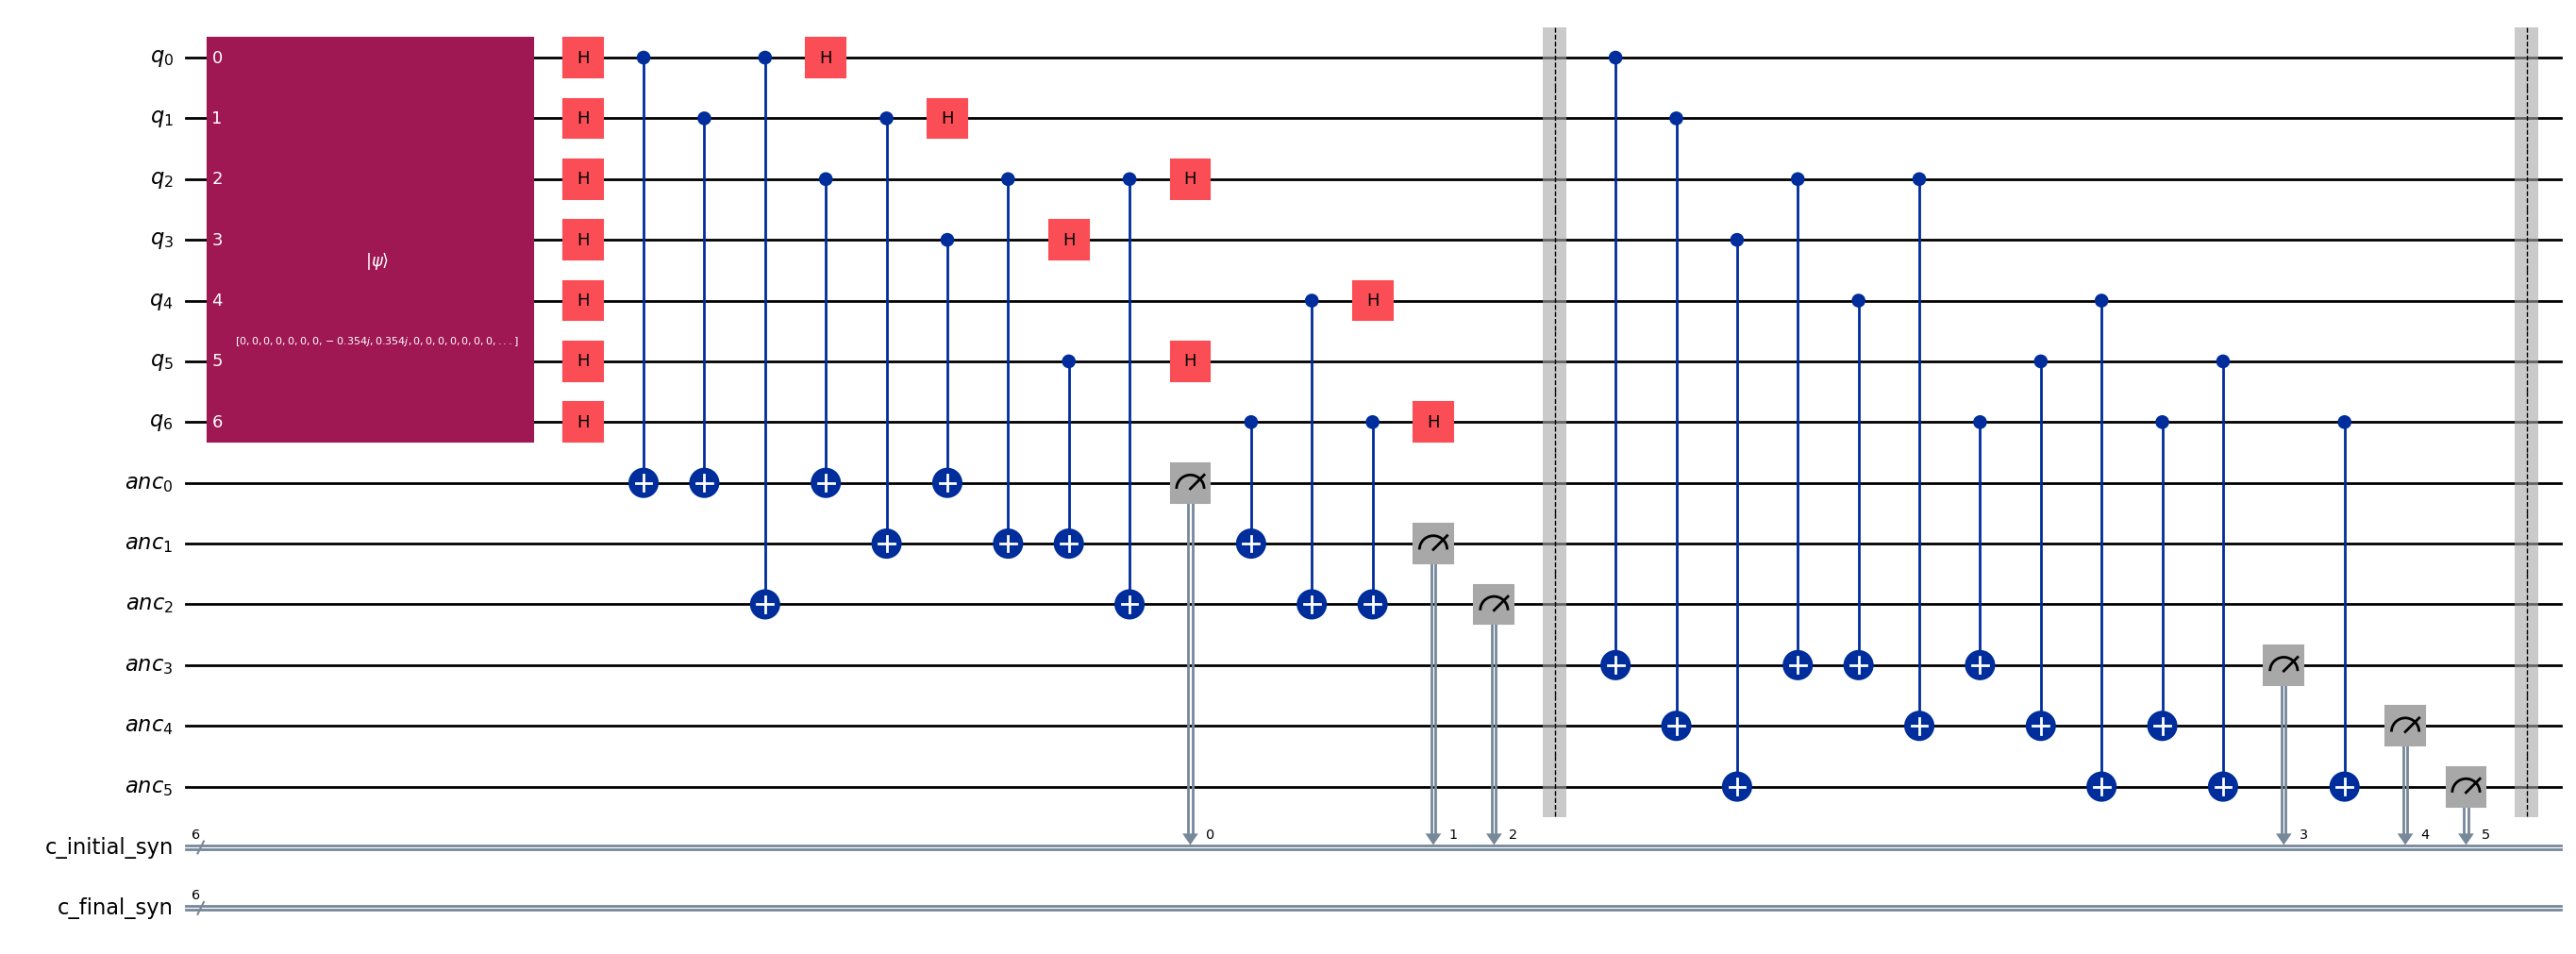

In [67]:
# --- AddSyndrome Measurement ---

measure_steane_syndrome(qc, qr_data, qr_anc, cr_initial_syn)

qc.draw('mpl', fold=-1)

Now, run this quantum circuit to find the error injected into the logical $∣0\rangle$ state. To complete this task, you'll need the key (the measured bitstring) from the `counts` dictionary. If the stabilizer measurements are implemented correctly, you will observe a single state with 100% probability in the simulation results.

<div class="alert alert-block alert-warning">
<b>To get a correct answer</b>

If you run the circuit below on a real backend, you might not be able to obtain the error codes accurately due to various errors injected into the qubits. Therefore, please execute the following code using a simulator backend.

</div>

In [68]:
# After you build `decoder` as before…

# 1) Show all syndrome patterns in the decoder:
print("Built decoder keys:", sorted(decoder.keys()))

# 2) For each single‐qubit Pauli, compute its syndrome and print if it matches '100001':
from qiskit.quantum_info import Pauli

print("\nChecking which error gives syndrome '100001':")
for q in range(7):
    for P in ("X","Y","Z"):
        pstr = ["I"]*7
        pstr[q] = P
        err = Pauli("".join(pstr))
        bits = ["0" if err.commutes(s) else "1" for s in stabs]
        key = "".join(bits)
        if key == "100001":
            print(f"Error {P}{q} → syndrome {key}")

Built decoder keys: ['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001100', '010000', '010010', '011000', '011110', '100000', '100001', '101000', '101101', '110000', '110011', '111000', '111111']

Checking which error gives syndrome '100001':
Error Y3 → syndrome 100001


In [69]:
# --- Run the Simulation using AerSimulator
backend = AerSimulator()

#make quantum circuit compatible to the backend
pm = generate_preset_pass_manager( backend = backend, optimization_level=3)
qc_isa = pm.run(qc)

#run and get counts
sampler = Sampler(mode=backend)
counts = sampler.run([qc_isa], shots = 10000).result()[0].data.c_initial_syn.get_counts()

# ---- TODO : Task 3 ---
#get key of simulation result and find the error code, ex: X1
#    pick the most frequent raw syndrome:
raw, _ = max(counts.items(), key=lambda kv: kv[1])
#    raw is in the same order as stab_strs → no reverse!
correction = decoder[raw]
print("Raw syndrome (S0…S5):", raw)
print("Decoded correction :", correction)

error_code = correction
# --- End of TODO ---

Raw syndrome (S0…S5): 100001
Decoded correction : Y3


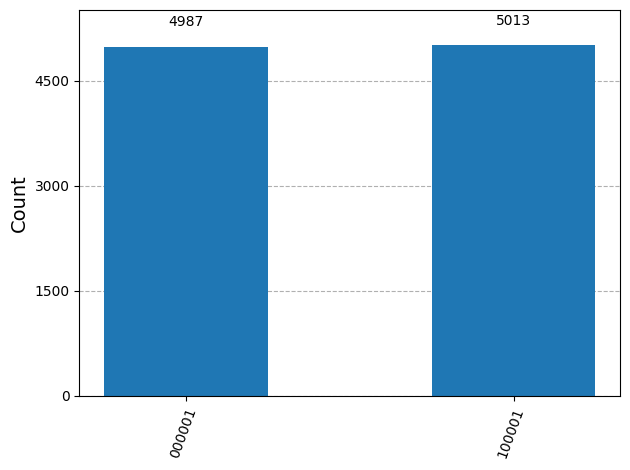

In [62]:
plot_histogram(counts)

Submit your error code string to grader to see if you detect correct.

In [70]:
# Submit your answer using following code
grade_lab4_ex3(error_code)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


In [71]:
# 1) Stabilizers in c0…c5 order
stab_strs = [
    "IIIXXXX",  # S0
    "IXXIIXX",  # S1
    "XIXIXIX",  # S2
    "ZIZIZIZ",  # S3
    "IZZIIZZ",  # S4
    "IIIZZZZ",  # S5
]
stabs = [Pauli(s) for s in stab_strs]

# 2) Build decoder map so key[0]=S0, …, key[5]=S5
decoder = {"000000": "I"}
for q in range(7):
    for P in ("X", "Y", "Z"):
        pstr = ["I"] * 7
        pstr[q] = P
        err = Pauli("".join(pstr))
        bits = ["0" if err.commutes(s) else "1" for s in stabs]
        decoder["".join(bits)] = f"{P}{q}"

# 3) Syndrome‐measurement subroutine
def measure_steane_syndrome(qc, qd, qa, cr):
    # ———— X‐type checks ————
    qc.h(qd)  # turn Z→X
    # S0 on [0,1,2,3]
    for i in [0,1,2,3]:
        qc.cx(qd[i], qa[0])
    # S1 on [1,2,5,6]
    for i in [1,2,5,6]:
        qc.cx(qd[i], qa[1])
    # S2 on [0,2,4,6]
    for i in [0,2,4,6]:
        qc.cx(qd[i], qa[2])
    qc.h(qd)
    qc.measure(qa[0:3], cr[0:3])
    qc.barrier()

    # ———— Z‐type checks ————
    # S3 on [0,2,4,6]
    for i in [0,2,4,6]:
        qc.cx(qd[i], qa[3])
    # S4 on [1,2,5,6]
    for i in [1,2,5,6]:
        qc.cx(qd[i], qa[4])
    # S5 on [3,4,5,6]
    for i in [3,4,5,6]:
        qc.cx(qd[i], qa[5])
    qc.measure(qa[3:6], cr[3:6])
    qc.barrier()

# 4) Build and run the full circuit
state = bring_states()                # from the grader
qd    = QuantumRegister(7, name="q")  
qa    = QuantumRegister(6, name="anc")
cr    = ClassicalRegister(6, name="c_syn")
qc    = QuantumCircuit(qd, qa, cr)

qc.initialize(state, qd)              # load the injected state
measure_steane_syndrome(qc, qd, qa, cr)

backend = AerSimulator()
pm      = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_isa  = pm.run(qc)
counts  = Sampler(mode=backend).run([qc_isa], shots=10_000).result()[0] \
             .data.c_syn.get_counts()

# 3) After you run and get `counts` (on c_reg[0:6]),
#    pick the most frequent raw syndrome:
raw, _ = max(counts.items(), key=lambda kv: kv[1])
#    raw is in the same order as stab_strs → no reverse!
correction = decoder[raw]
print("Raw syndrome (S0…S5):", raw)
print("Decoded correction :", correction)

plot_histogram(counts)

# 6) Submit to the grader
grade_lab4_ex3(correction)

Raw syndrome (S0…S5): 100001
Decoded correction : Y3
Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


Congratulations! You've successfully implemented the stabilizer measurement circuit for the Steane code and detected the error.

Since Pauli errors are unitary operations and self-inverse, applying the same Pauli gate a second time acts as the identity operation ($P \cdot P=I$), effectively canceling the error. For this optional exercise (non-graded), use this property to correct the error you detected. Apply the gate corresponding to your detected error code to the erroneous quantum state and verify that the error is corrected.

<div class="alert alert-block alert-success">
<b>No Grader Extra Exercise: Correct Error</b>

Now let's correct this error with a proper gate operation. 

Complete below cell to add proper correction and then do a stabilizer measure one more to get syndrom measurement result: $000000$ which means no error detected. Start from initialize qr_data with State again and apply correction gate, then do a stabilizer measure. You can use `measure_steane_syndrome` function you already made.

</div>

In [ ]:
qc = QuantumCircuit(qr_data, qr_anc, cr_initial_syn, cr_final_syn)

# ---- TODO : ungraded task ---
#initialize qr_data with State and correct error by applying proper gate



# --- End of TODO ---

measure_steane_syndrome(qc, qr_data, qr_anc, cr_final_syn)

#qc.draw('mpl', fold=-1)

<div class="alert alert-block alert-warning">
<b>To get a correct answer</b>

If you run the circuit below on a real backend, you might not be able to obtain the error codes accurately due to various errors injected into the qubits. Therefore, please execute the following code using a simulator backend.

</div>

In [ ]:
qc_isa = pm.run(qc)
counts = sampler.run([qc_isa], shots = 10000).result()[0].data.c_final_syn.get_counts()

plot_histogram(counts)

Did you obtain `000000` with 100% probability in your syndrome measurements? Congratulations 🎉! You now understand the Steane code and how to detect and correct errors.

So far, you've explored the fundamental concepts of both classical and quantum error correction. You've delved into the operational mechanics of two foundational quantum error correction codes, constructed lookup tables for error detection and correction, and practically applied these principles by detecting errors in the Steane code.



# Chapter 3: Exploring Advanced Quantum Error Correction Codes & Their Efficiency

Having explored basic quantum error correction codes like the Steane code, this chapter delves into more advanced topics. Our primary goal is to understand different strategies for achieving robust fault tolerance and to investigate what improvements advanced QLDPC constructions (such as the Gross code and related families) offer over other well-known codes like Surface/Toric codes, particularly in terms of error correction capabilities and efficiency.

We will explore codes with particular topologies, where the geometric layout and connectivity of qubits influence the code's properties. We will analyze instances of the toric code and compare them with the gross code. For these, our focus will be on aspects like their parity check matrices and the number of logical qubits each can encode relative to physical qubits and distance.  This exploration will highlight different strategies for achieving fault-tolerance and shed light on the diverse landscape of contemporary QEC research.



<div class="alert alert-block alert-info">
    
<b> Note on Code Representations and a Pedagogical Approach </b>

It's essential to reiterate that the primary objective here is to understand comparative principles. The specific examples or graphical representations used in this chapter to illustrate differences between code families (e.g., Surface/Toric vs. Gross-like codes) should be understood as **illustrative toy models**. They are designed to capture essential characteristics and distinguishing features that lead to different performance potentials, rather than being the exact process of building codes.

</div>

## 3.1 Foundational Concepts and Key QLDPC Architectures for Comparison

Before directly introducing the toric/gross code, this section will give you a high-level introduction to the *Quantum Low-Density Parity-Check (QLDPC) codes* and introduce key qLDPC architectures.

Low-Density Parity-Check (LDPC) codes are classical error-correcting codes known for having a sparse parity check matrix, meaning the matrix contains very few non-zero entries relative to its size. This sparsity is crucial because it allows for highly efficient decoding algorithms, making LDPC codes powerful tools for classical communication and data storage. Quantum Low-Density Parity-Check (QLDPC) codes are the quantum counterparts to classical LDPC codes. In QLDP codes, the **stabilizer generators are sparse**; each stabilizer generator acts non-trivially on only a small number of qubits, and each qubit is only a part of a small number of these generators. The aim is to design codes that not only feature this beneficial sparsity but also achieve good scaling of code distance $d$ (a measure of error correction capability) with the number of physical qubits $n$, and ideally offer high **encoding rates** ($k/n$, where $k$ is the number of logical qubits).

Now that we've covered these basics, we'll look at and compare the two main types of QLDP codes:

* **Surface/Toric Codes**: These are well-studied QLDP codes defined on a 2D lattice where stabilizers act geometrically **locally** (typically on nearest-neighbor qubits). While known for relatively high error thresholds and compatibility with 2D hardware, their code distance $d$ typically scales as $O(\sqrt{n})$ for $n$ physical qubits, which can be a limitation for achieving very large distances efficiently and additionally, for each patch of surface (or toric) code, there is only 1 logical qubit (2 in the case of the toric code).

* **Bivariate Bicycle Codes (and related QLDPC families)**: This broader class of QLDPC constructions aims for excellent asymptotic scaling of parameters $k, d, n$. Their construction does not necessarily restrict them to simple 2D geometric locality. The Tanner graphs of these codes might exhibit more complex or **"long-range"** (in a 2D sense) connections, while still maintaining overall sparsity. This different structural connectivity is believed to underpin their potential for superior performance, such as:
    * Better distance scaling: Achieving a code distance $d$ that grows more favorably with $n$.
    * Higher encoding rates ($k/n$): Encoding more logical qubits for a similar number of physical qubits and distance.

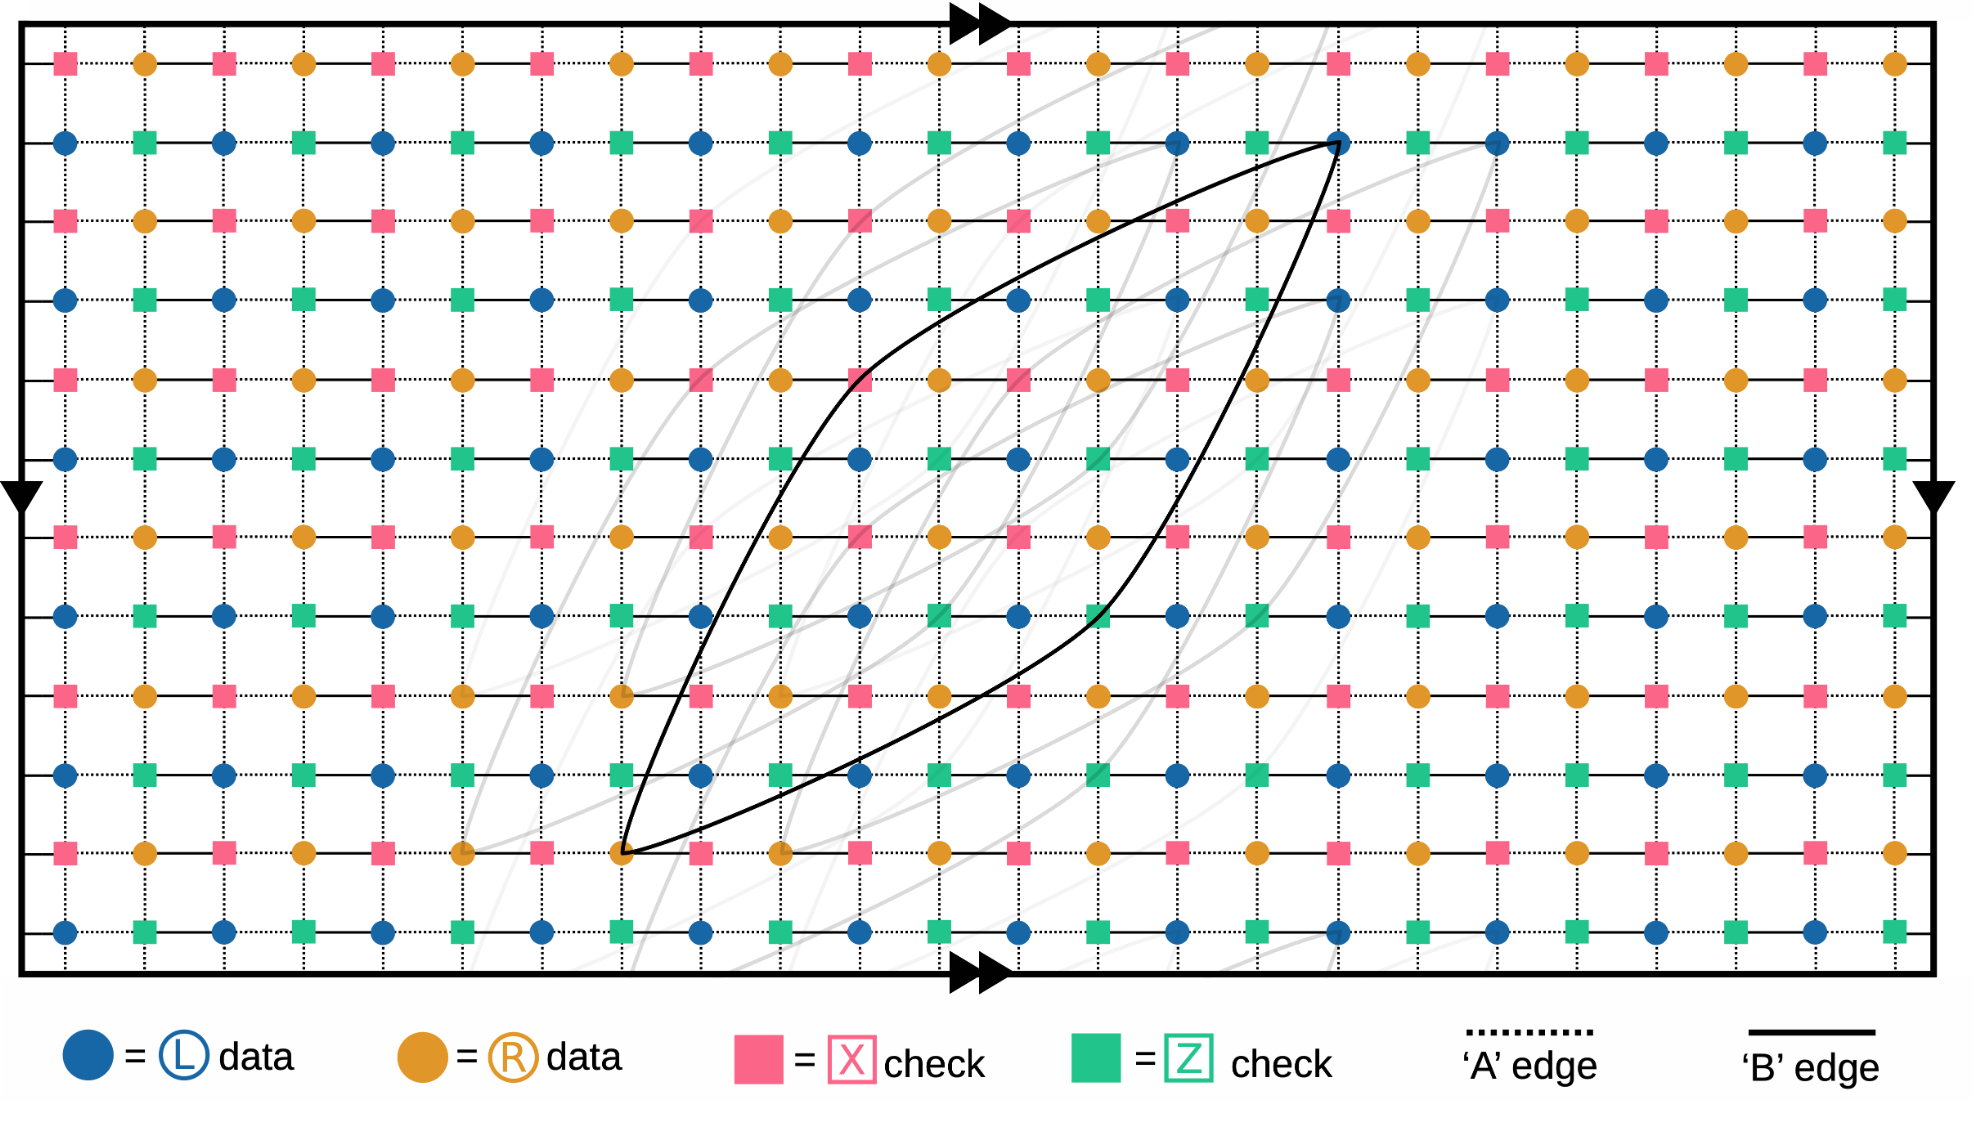

*(Image taken from https://arxiv.org/pdf/2308.07915: Tanner graph representation for the Gross code, illustrating data qubits (circles) and stabilizers/checks (squares) on a toroidal grid.)*

## 3.2 Qubit Layout and Conventions for Exercises

To concretely compare how different code structures impact performance with simplified models, we will construct codes on the same physical arrangement of qubits by using above image. We will build upon concepts discussed in the lecture "Toward Fault-tolerant Quantum Computing with IBM qLDPC codes" by Patrick Rall.

Our focus will be on constructing the parity check matrices for two illustrative code instances on a two-dimensional grid with periodic boundary conditions (a torus), as visualized in the provided Tanner graph:
1.  One representing a **Toric code** with local connections.
2.  Another representing a **Gross code** that incorporates additional long-range connections.

**Key Elements in Our Model:**

* **Data Qubits (Circles)**: Store the quantum information. In the provided diagram, these are the blue and orange circles. There are $12 \times 6 = 72$ blue qubits and $12 \times 6 = 72$ orange qubits, totaling $n = 144$ data qubits.
* **Stabilizers/Checks (Squares)**: Define the code's stabilizer operators.
    * **X-stabilizers** (products of Pauli-X) are associated with the **red** squares.
    * **Z-stabilizers** (products of Pauli-Z) are associated with the **green** squares.
* **CSS Code Structure**: We are working within the Calderbank-Shor-Steane (CSS) framework.

A clear **qubit labeling** convention is crucial for translating the Tanner graph's connectivity into parity check matrices. The rows of these matrices will correspond to stabilizers, and columns to data qubits.

**Qubit Labeling Convention (144 total data qubits):**

* **Blue** Data Qubits (Indices 0-71): Labeled column by column (left to right), then bottom-up within each column (0-indexed).
    * The bottom-leftmost blue qubit is `0`; the one above it is `1`, up to `5`.
    * The next column's blue qubits are `6` through `11`, and so on.
* **Orange** Data Qubits (Indices 72-143): Follow the same labeling scheme, starting with the bottom-leftmost orange qubit as `72`.

**Parity Check Matrix Convention (for this lab):**

We will define two binary parity check matrices:

* **$H_X$ (for X-stabilizers)**:
    * Each row represents an X-stabilizer (derived from a **red square**).
    * This matrix $H_X$ is used to detect **Z-type errors**. (Syndrome: $s_x$)
* **$H_Z$ (for Z-stabilizers)**:
    * Each row represents a Z-stabilizer (derived from a **green square**).
    * This matrix $H_Z$ is used to detect **X-type errors**. (Syndrome: $s_z$)


Using the layout and conventions above, we will now define stabilizers based on the connectivity depicted in the provided Tanner graph for two distinct code versions on the *same* physical qubit layout as exercises.

1.  **The Toric Code:** This version will be constructed using only local, nearest-neighbor connections between the stabilizers (squares) and the data qubits (circles) they act upon, following the standard toric code model on a grid with periodic boundaries. Note: the Toric code is very similar to the Surface code, however it is embedded on a torus with periodic boundaries in both the $x$ and $y$ directions. In particular, it can encode one additional qubit when compared to the surface code without the periodic boundaries.
2.  **The Gross Code:** This version will augment the local connections typical of the toric code by including specific "long-range" connections, leaf shape connection of above graph. These additional connections modify the definitions of the stabilizer generators, leading to a code with different parameters and properties compared to the standard toric code on the same qubit layout.

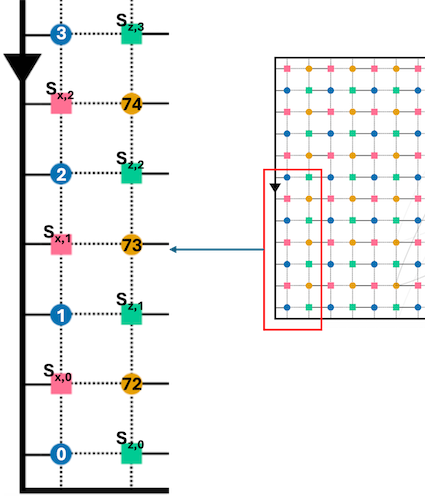



## 3.3 Toric Code Exercise


We will now establish the binary representation for the **X-stabilizers** (associated with red squares) for the toric code, which considers only nearest-neighbor connections on the torus. These will form the rows of the matrix you'll be asked to construct (referred to as $H_X$ in the exercise prompt's output variable.

Let's consider the bottom-leftmost red square in the diagram. This X-stabilizer acts on four neighboring data qubits:
1.  The blue data qubit below it: This is blue qubit `0` (column 0, row 0).
2.  The blue data qubit above it: This is blue qubit `1` (column 0, row 1).
3.  The orange data qubit to its right: This is the bottom-leftmost orange qubit, which is orange qubit `72` (orange column 0, row 0).
4.  The orange data qubit to its left (across the periodic boundary): This is the bottom-rightmost orange qubit. Orange qubits are indexed 72-143. There are 12 columns of orange qubits, 6 qubits per column. The last orange column (column 11) contains qubits $72 + 11 \times 6 + $ row_idx. The bottom-rightmost is $72 + 11 \times 6 + 0 = 72 + 66 = 138$. So, this is orange qubit `138`.

Therefore, the first X-stabilizer acts on data qubits `0`, `1`, `72`, and `138`. Its corresponding row in the binary matrix (which will be a row in your $H_X$ for the exercise, or $H_Z$ in standard notation) will have 1s at columns 0, 1, 72, and 138, and 0s elsewhere. This 144-element row vector is:

`[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]`

The example given in the original problem for the first 6 rows of "parity check matrix $H_X$" (derived from the first 6 red squares) uses this logic:

`
  [[ 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
   [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
   [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
   [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
   [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
   [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
     0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
`

<div class="alert alert-block alert-success">
<b>Exercise 4: Find the parity check matrices of the toric code</b>

Following the above convention for qubit labeling and the definition of stabilizers from the diagram, find the parity check matrices for the **toric code** (i.e., the code containing only nearest-neighbor connections).

Output the result for the **X-stabilizers (red squares)** in a NumPy array labelled $H_{X}$ and similarly for the **Z-stabilizers (green squares)** in a NumPy array labelled $H_{Z}$.(As per our clarification note, the matrix $H_X$ you generate from red squares will be used to detect Z-errors, and $H_Z$ from green squares will detect X-errors).

Please ensure that the NumPy arrays - $H_{X}$ and $H_{Z}$, strictly adhere to the expected dimensions and structure(`np.zeros((144,144),dtype=int)`). Modifying the size or structure of these matrices from what is anticipated by the exercise might lead to a failure during grading.


**Hint**: Notice the periodic structure in the examples. Can this be used to your advantage to write an efficient piece of code to generate these matrices? 
</div>





In [154]:
# Some helpful code to start Exercise 4.
# Hint: you can use the m_power function imported from numpy.linalg

# We will define the parity check matrices for the toric code
HXtc = np.zeros((72, 144),dtype=int) # initializing the matrices
HZtc = np.zeros((72, 144),dtype=int)
HXgc = np.zeros((72, 144),dtype=int) # initializing the matrices
HZgc = np.zeros((72, 144),dtype=int)

# We will ask you to modify the matrices by adding 1s in appropriate places
# As an example, we will show how to do so for the first few rows of the toric code

# 0-th stabilizer
HXtc[0][0] = 1
HXtc[0][1] = 1
HXtc[0][72] = 1
HXtc[0][138] = 1

# 1-st stabilizer
HXtc[1][1] = 1
HXtc[1][2] = 1
HXtc[1][73] = 1
HXtc[1][139] = 1

# 2-nd stabilizer
HXtc[2][2] = 1
HXtc[2][3] = 1
HXtc[2][74] = 1
HXtc[2][140] = 1

# 3-rd stabilizer
HXtc[3][3] = 1
HXtc[3][4] = 1
HXtc[3][75] = 1
HXtc[3][141] = 1

# 4-th stabilizer
HXtc[4][4] = 1
HXtc[4][5] = 1
HXtc[4][76] = 1
HXtc[4][142] = 1

# 5-th stabilizer
HXtc[5][5] = 1
HXtc[5][np.mod(6,6)] = 1
HXtc[5][72 + 5] = 1
HXtc[5][72 + 6*np.mod(-1,12) + 5] = 1

# The last definition suggested a general rule for finding the appropriate locations to place 1s
# HXtc[j][j] = 1
# HXtc[j][6*np.floor(j/6) + np.mod(j+1,6)]
# HXtc[j][j+72] = 1
# HXtc[j][72 + 6*np.mod(np.floor(j/6)-1,12) + np.mod(j,6)]

# Write a loop over j from 0 to 143 to set all of the rows.

# Inspired from this, write a similar loop for the Z parity check matrices.


import numpy as np

ROWS, COLS = 6, 12
N_STAB, N_QUB = ROWS * COLS, 144          # 72 × 144

HXtc = np.zeros((N_STAB, N_QUB), dtype=int)   # red-square  X-stabilisers
HZtc = np.zeros((N_STAB, N_QUB), dtype=int)   # green-square Z-stabilisers

for s in range(N_STAB):
    r = s % ROWS            # square row   0‥5  (bottom → top)
    c = s // ROWS           # square col   0‥11 (left   → right)

    # ───────── X-stabiliser (red square) ──────────────────────────────
    HXtc[s, 6*c + r]                       = 1      # blue below
    HXtc[s, 6*c + (r+1) % ROWS]            = 1      # blue above
    HXtc[s, 72 + 6*c + r]                  = 1      # orange right
    HXtc[s, 72 + 6*((c-1) % COLS) + r]     = 1      # orange left (wrap)

    # ───────── Z-stabiliser (green square) ────────────────────────────
    HZtc[s, 72 + 6*c + r]                  = 1      # orange bottom
    HZtc[s, 72 + 6*c + (r-1) % ROWS]       = 1      # orange *top*   (row r-1)
    HZtc[s, 6*c + r]                       = 1      # blue  left     (row r)
    HZtc[s, 6*((c+1) % COLS) + r]          = 1      # blue  right    (row r)

# ── sanity checks --------------------------------------------------------

# ---------------- sanity print ------------------------------------------
def idxs(row): return np.flatnonzero(row).tolist()

print("HX row 0:", idxs(HXtc[0]))   # → [0, 1, 72, 138]
print("HZ row 0:", idxs(HZtc[0]))   # → [0, 6, 72, 73]
print("HX row 5:", idxs(HXtc[5]))   # → [0, 5, 77, 143]
print("HZ row 5:", idxs(HZtc[5]))   # → [5, 11, 72, 77]

# ---------------- self-consistency checks -------------------------------
assert HXtc.shape == (72, 144) and HZtc.shape == (72, 144)
assert (HXtc.sum(axis=1) == 4).all() and (HZtc.sum(axis=1) == 4).all()
assert ((HXtc @ HZtc.T) % 2 == 0).all(), "X and Z stabilisers must commute"
assert (HXtc.sum(axis=0) == 2).all() and (HZtc.sum(axis=0) == 2).all()


HX row 0: [0, 1, 72, 138]
HZ row 0: [0, 6, 72, 77]
HX row 5: [0, 5, 77, 143]
HZ row 5: [5, 11, 76, 77]


In [155]:
import numpy as np

def idxs(row):          # indices of 1-entries for quick reading
    return np.flatnonzero(row).tolist()

def print_boundary_stabs(HX, HZ):
    ROWS, COLS = 6, 12
    printed = set()                   # avoid duplicates

    for c in range(COLS):
        for r in (0, ROWS-1):         # bottom and top rows
            printed.add(6*c + r)

    for r in range(ROWS):
        for c in (0, COLS-1):         # leftmost and rightmost columns
            printed.add(6*c + r)

    for s in sorted(printed):
        r, c = s % ROWS, s // ROWS
        print(f"Square at (c={c}, r={r}) → row {s:2d}")
        print("  HX:", idxs(HX[s]))
        print("  HZ:", idxs(HZ[s]))
        print("-" * 40)

# example call (assumes HXtc and HZtc are already built)
print_boundary_stabs(HXtc, HZtc)

Square at (c=0, r=0) → row  0
  HX: [0, 1, 72, 138]
  HZ: [0, 6, 72, 77]
----------------------------------------
Square at (c=0, r=1) → row  1
  HX: [1, 2, 73, 139]
  HZ: [1, 7, 72, 73]
----------------------------------------
Square at (c=0, r=2) → row  2
  HX: [2, 3, 74, 140]
  HZ: [2, 8, 73, 74]
----------------------------------------
Square at (c=0, r=3) → row  3
  HX: [3, 4, 75, 141]
  HZ: [3, 9, 74, 75]
----------------------------------------
Square at (c=0, r=4) → row  4
  HX: [4, 5, 76, 142]
  HZ: [4, 10, 75, 76]
----------------------------------------
Square at (c=0, r=5) → row  5
  HX: [0, 5, 77, 143]
  HZ: [5, 11, 76, 77]
----------------------------------------
Square at (c=1, r=0) → row  6
  HX: [6, 7, 72, 78]
  HZ: [6, 12, 78, 83]
----------------------------------------
Square at (c=1, r=5) → row 11
  HX: [6, 11, 77, 83]
  HZ: [11, 17, 82, 83]
----------------------------------------
Square at (c=2, r=0) → row 12
  HX: [12, 13, 78, 84]
  HZ: [12, 18, 84, 89]
--------

In [156]:
import numpy as np

# -- find the first (X-row, Z-row) pair that does NOT commute ----------
M = (HXtc @ HZtc.T) % 2          # 72 × 72 matrix of pair-wise overlaps
bad = np.argwhere(M == 1)        # rows where overlap count is odd

print(f"Total non-commuting pairs: {len(bad)}")
if bad.size:
    i, j = bad[0]                # take the first offending pair
    print(f"\nFirst offending pair:  HX row {i}   vs   HZ row {j}\n")

    def idxs(row): return np.flatnonzero(row).tolist()

    print("HX indices:", idxs(HXtc[i]))
    print("HZ indices:", idxs(HZtc[j]))

Total non-commuting pairs: 0


In [160]:
# Submit your answer using following code
grade_lab4_ex4(HXtc, HZtc)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


## 3.4 Gross Code Exercise

Now we consider the parity check matrices for the Gross(-like) code. This code is generated by including the long-range connections shown abstractly in the figure (e.g., the leaf-like diagonal connections, though the exact rules are specific to the code's definition). The fundamental qubit layout and labeling convention remain the same as for the toric code.

The key difference for the Gross code is that each stabilizer (square check) will now have two additional long-range connections on top of its four nearest-neighbor connections. This means each stabilizer in the Gross code will act on a total of $4+2=6$ data qubits. Consequently, each row in the parity check matrices ($H_X$ and $H_Z$) for the Gross code will have six '1's.

A practical way to construct these matrices is to start with the toric code's connectivity (nearest-neighbor connections) and then add the two specific long-range connections for each stabilizer.

Let's illustrate this for the first row of $H_X$, which corresponds to the X-stabilizer at the bottom-leftmost red square(conceptually at $c_s=0, r_s=0$).



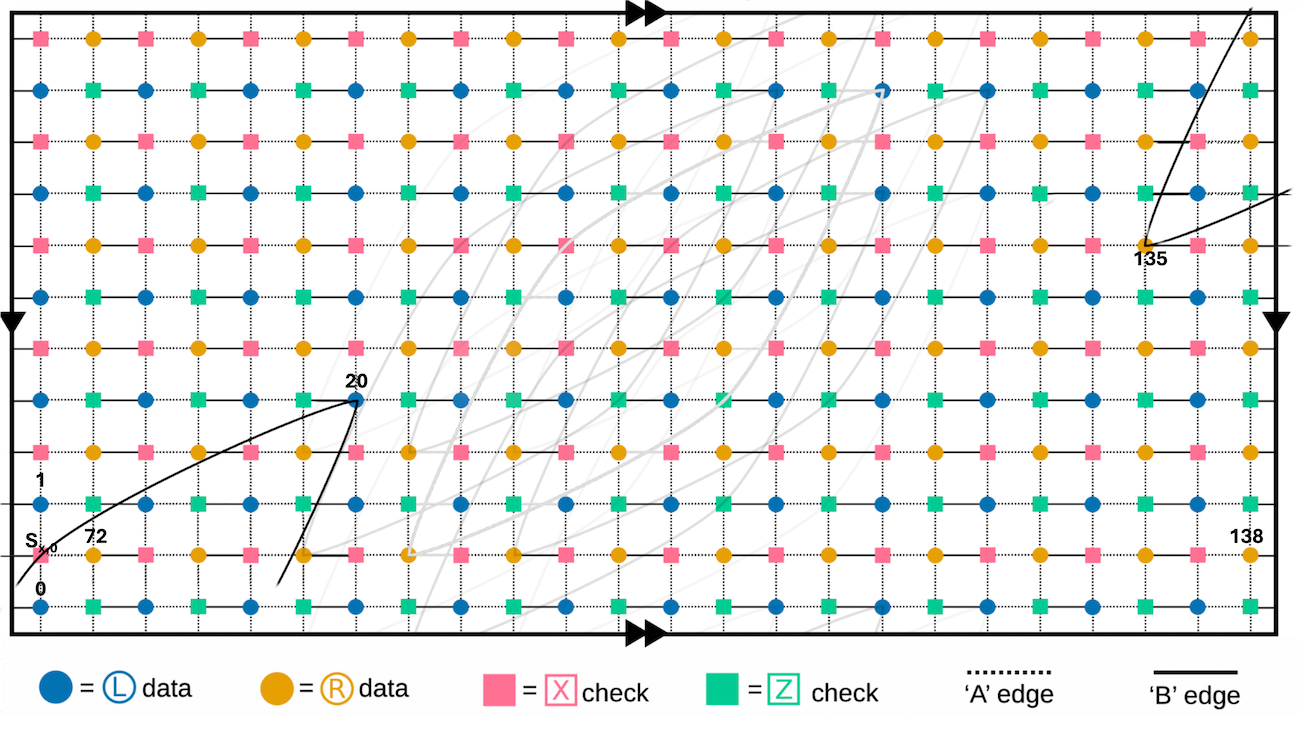

1. Nearest-Neighbor Connections (from Toric Code):
As established in Section 3.3, this bottom-leftmost red square has nearest-neighbor connections to:
* Blue data qubit at index $\mathbf{0}$ (visualized as "below" or part of the square, blue column 0, row 0).
* Blue data qubit at index $\mathbf{1}$ (visualized as "above" or part of the square, blue column 0, row 1).
* Orange data qubit at index $\mathbf{72}$ (visualized as "to the right" or part of the square, orange column 0, row 0).
* Orange data qubit at index $\mathbf{138}$ (visualized as "to the left" across periodic boundary, orange column 11, row 0).

2. Additional Long-Range Connections (Specific to this Gross Code instance):
The problem states that for this particular Gross code construction, the bottom-leftmost red square ($c_s=0, r_s=0$) will have two additional long-range connections:

* First long-range connection: To the blue data qubit 20.
    * The text describes this as "the blue qubit three rows above and six columns to the right." The specific rules of the Gross code define how these relative positions map to a precise qubit index on the torus. For this stabilizer, this rule results in a connection to blue data qubit with global index $\mathbf{20}$.

* Second long-range connection: To the orange data qubit 135.
    * The text describes this as "the orange qubit three columns to the left and six rows down (recall the periodic boundary conditions)." Again, these relative descriptions are specific to the Gross code's connection rules for this stabilizer, resulting in a connection to orange data qubit with global index $\mathbf{135}$.

3. Resulting First Row of $H_X$ for the Gross Code:
Combining both nearest-neighbor and the two specified long-range connections, the bottom-leftmost X-stabilizer now acts on data qubits with indices: `0, 1, 20, 72, 135, 138`.

Therefore, the first row of the $H_X$ matrix for this Gross code (a 144-element binary vector) will have '1's at these six positions and '0's elsewhere. Let's verify this against the provided snippet:

**Snippet:**

`[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]`

This confirms that the snippet for the first row of $H_X$ for the Gross code has exactly six '1's at the global data qubit indices 0, 1, 20, 72, 135, and 138, matching the combination of nearest-neighbor and the specified long-range connections.

This process of adding two specific long-range connections would be repeated for *every* stabilizer (both X-type from red squares and Z-type from green squares) to transform the toric code matrices into the Gross code matrices. The exact rules for determining the long-range partners for other stabilizers would follow a consistent pattern defined by the Gross code's construction on this lattice.

<div class="alert alert-block alert-success">
<b>Exercise 5: Find the parity check matrices of the gross code </b>

Following the above labelling convention, construct the parity check matrix for the gross code, that is, including the long-range connections. Output the result for the $X$ stabilizers in numpy array labelled $H_{X}$ and similarly for the $Z$ stabilizers in an array labelled $H_{Z}$.

**Hint**: Notice the periodic structure of the above examples, can this be used to your advantage to make an efficient piece of code to generate the matrices. Each row should be weight-6, that is have six 1s.

</div>

In [ ]:
# We will define the parity check matrices for the gross code
HXgc = np.zeros((72, 144),dtype=int) # initializing the matrices
HZgc = np.zeros((72, 144),dtype=int)

# 0-th stabilizer
HXgc[0][0] = 1
HXgc[0][1] = 1
HXgc[0][20] = 1
HXgc[0][72] = 1
HXgc[0][135] = 1
HXgc[0][138] = 1

# ---- TODO : Task 5 ---
import numpy as np

# ── lattice helpers ──────────────────────────────────────────────────────
ROWS, COLS = 6, 12
b = lambda c, r:  6*c + r               # blue   (vertical) qubit index
o = lambda c, r: 72 + 6*c + r           # orange (horizontal) qubit index

N_STAB, N_QUB = ROWS * COLS, 144        # 72 stabilisers, 144 data qubits
HXgc = np.zeros((N_STAB, N_QUB), dtype=int)
HZgc = np.zeros((N_STAB, N_QUB), dtype=int)

for c in range(COLS):
    for r in range(ROWS):
        s = 6*c + r                     # row index for this square

        # ── X-stabiliser (red square) ───────────────────────────────────
        HXgc[s, [b(c,r), b(c,(r+1)%6),
                 o(c,r), o((c-1)%12, r),
                 b((c+3)%12, (r+2)%6),           # blue leaf  +3c,+2r
                 o((c-2)%12, (r+3)%6) ]] = 1     # orange leaf −2c,+3r

        # ── Z-stabiliser (green square) ────────────────────────────────
        HZgc[s, [o(c,r), o(c,(r-1)%6),           # orange bottom & *top*
                 b(c,r), b((c+1)%12, r),         # blue left & right
                 b((c+2)%12, (r+3)%6),           # blue leaf  +2c,+3r
                 o((c-3)%12, (r+4)%6) ]] = 1     # orange leaf −3c,+4r

# ── verification ---------------------------------------------------------
assert (HXgc.sum(axis=1) == 6).all() and (HZgc.sum(axis=1) == 6).all()
assert ((HXgc @ HZgc.T) % 2 == 0).all(), "X and Z stabilisers must commute"

# quick spot-check 
def idxs(row): return np.flatnonzero(row).tolist()
print("HXgc row 0:", idxs(HXgc[0]))   # [0, 1, 20, 72, 135, 138]
print("HZgc row 0:", idxs(HZgc[0]))   # [0, 6, 15, 72, 77, 130]

# ------------------------------------------------------------------------
# HXgc   and   HZgc   are the Gross-code parity-check matrices
# (shape 72 × 144, weight-6 rows, commuting) ready for the lab.
# --- End of TODO ---

HXgc row 0: [0, 1, 20, 72, 135, 138]
HZgc row 0: [0, 6, 15, 72, 77, 130]


In [175]:
# Submit your answer using following code
grade_lab4_ex5(HXgc, HZgc)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


## 3.5 Counting the Number of Logical Qubits

The parity check matrices you've been working with, $H_X$ and $H_Z$, are constructed from the stabilizers of the code. Each row in these matrices represents a generator of the stabilizer group. However, it's possible that some of these chosen generators are not independent; one stabilizer generator might be a product of others. Redundant generators don't add new constraints to define the codespace.

To find the actual number of independent stabilizer generators, we calculate the **rank** of these parity check matrices. Since we are dealing with qubits and Pauli operators (which square to identity and whose effects are often considered over GF(2) in the context of their binary representation), all matrix operations for rank calculation are performed modulo 2. The rank tells us the true number of unique conditions imposed by the stabilizers.

In general, for a quantum stabilizer code:
If $n$ is the number of physical data qubits used in the code, and $r$ is the total number of independent stabilizer generators, then the number of logical qubits ($k$) encoded by the code is given by:
$$k = n - r$$
Each independent stabilizer generator effectively halves the dimension of the Hilbert space, "fixing" one degree of freedom. Thus, $r$ independent stabilizers reduce the $2^n$-dimensional space of $n$ physical qubits to a $2^{n-r}$-dimensional codespace, which can then encode $k = n-r$ logical qubits.

For CSS codes, like the toric and Gross codes we are considering, the X-stabilizers and Z-stabilizers form two distinct, commuting groups. This allows us to count their independent generators separately.
If $r_X$ is the number of independent X-stabilizers (obtained from the rank of the matrix whose rows are the X-stabilizer generators, which you've labeled $H_X$ from red squares) and $r_Z$ is the number of independent Z-stabilizers (obtained from the rank of the matrix whose rows are the Z-stabilizer generators, labeled $H_Z$ from green squares), then the number of logical qubits in the CSS code is:
$$k = n - r_X - r_Z$$
This formula holds because the X-stabilizers and Z-stabilizers are chosen such that they all commute with each other, and the total number of independent conditions imposed on the codespace is the sum of the independent X-type and Z-type conditions.



<div class="alert alert-block alert-success">
<b>Exercise 6: Count the number of logicals for the Toric and Gross codes</b>

You will now use the `matrixRank` function to determine the number of logical qubits for both the toric code and the Gross code you constructed in Exercises 4 and 5.

1.  Import the function: Start by importing the `matrixRank` function using the command:
    `from lab4_util import matrixRank`
    This function calculates the rank of a binary matrix over GF(2), which is exactly what we need for our parity check matrices.

2.  Calculate Ranks:
    * For the toric code, use `matrixRank` to find the rank of $H_X$ (the matrix of X-stabilizers you generated from red squares in Exercise 4) – this will give you $r_{X, \text{toric}}$.
    * Similarly, find the rank of $H_Z$ (the matrix of Z-stabilizers from green squares in Exercise 4) – this will give you $r_{Z, \text{toric}}$.
    * Repeat this process for the Gross code matrices ($H_X$ and $H_Z$) you generated in Exercise 5 to find $r_{X, \text{gross}}$ and $r_{Z, \text{gross}}$.

3.  Calculate Logical Qubits ($k$):
    * Using the formula $k = n - r_X - r_Z$ (where $n=144$ is the total number of data qubits), calculate the number of logical qubits for the toric code ($k_{\text{toric}}$).
    * Perform the same calculation for the Gross code ($k_{\text{gross}}$).

**Grading**: Submit the calculated ranks ($r_X$, $r_Z$) and the number of logical qubits ($k$) for both the toric code and the Gross code. You can verify your toric code result against the known fact that it encodes $k=2$ logical qubits.
</div>

In [176]:
# ---- TODO : Task 6 ---
import numpy as np
from lab4_util import matrixRank       # GF-(2) rank

# ------------------------------------------------------------------
# 1)  ranks for the toric-code matrices you built in Exercise 4
rX_toric = matrixRank(HXtc)            # rows = red-square  X-stabilisers
rZ_toric = matrixRank(HZtc)            # rows = green-square Z-stabilisers

# 2)  ranks for the Gross-code matrices from Exercise 5
rX_gross = matrixRank(HXgc)
rZ_gross = matrixRank(HZgc)

# 3)  logical-qubit counts  k = n − rX − rZ   with n = 144 data qubits
n = 144
k_toric = n - rX_toric - rZ_toric
k_gross = n - rX_gross - rZ_gross

print(f"Toric code : r_X = {rX_toric:2d}, r_Z = {rZ_toric:2d},  k = {k_toric}")
print(f"Gross code : r_X = {rX_gross:2d}, r_Z = {rZ_gross:2d},  k = {k_gross}")
# --- End of TODO ---

Toric code : r_X = 71, r_Z = 71,  k = 2
Gross code : r_X = 66, r_Z = 66,  k = 12


In [177]:
# Submit your answer using following code
grade_lab4_ex6(k_toric, k_gross)

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.


## 3.6 Concluding remarks: The power of the connectivity

These exercises demonstrate a key principle in Quantum Error Correction: strategic modifications to a code's underlying structure, such as introducing long-range connections, can significantly enhance its performance.

The construction of parity check matrices for both the toric-like and Gross-like codes on the identical $144$-data-qubit framework has been completed. Your calculations in Exercise 6 for the number of logical qubits ($k$) illustrate how these differing connectivities influence $k_{\text{Gross}}$ relative to the standard $k_{\text{toric}}$.

However, a more pronounced advantage of the Gross code variant is evident in its **code distance ($d$)**, a critical parameter dictating its error correction strength. While detailed distance calculations are beyond this lab's immediate scope, but for the above code instances the toric code would be of distance 6 (as the periodicity along one of the directions is 6 lattice spacing in terms of the number of data qubits), however the gross code would have distance 12! 


This substantial improvement in error correction capability, achieved by adding specific long-range connections, underscores the impact of such structural modifications on code performance, particularly in enhancing protection against errors. This highlights a valuable strategy in the design of advanced quantum codes.

# Additional information

**Created by:** Sophy Shin, Tomas Jochym-O'Connor, Sebastian Brandhofer

**Advised by:**  Blake Johnson, Patrick Rall, Henry Zou, Olivia Lanes

**Version:** 1.0